In [1]:
!pip install -q ipyleaflet scipy

import itertools
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import ipywidgets as widgets

from scipy.cluster.hierarchy import linkage, dendrogram
from collections import defaultdict
from util import dataset
from util.geo import mean_latlong, latlong_from_3d, latlong_to_3d, euclidian_dist, haversine_dist

from ipyleaflet import Marker, Map, CircleMarker, MarkerCluster

## Inferir lugar do usuários

- Faz join entre business, review e tip para saber a lat/lng de todas as iterações do usuário
- Clusteriza iterações de cada usuário, onde eventos a menos de 10km de distancia pertencem ao mesmo cluster
- Associa usuário ao centróide do cluster com mais elementos

In [2]:
user_names = {
    user['user_id']: user['name']
    for user in dataset.read('user')
}
len(user_names)

1518168

In [3]:
business_latlng = {
    x['business_id']: (x['latitude'], x['longitude'])
    for x in dataset.read('business')
    if x['latitude'] is not None and x['longitude'] is not None
}

In [4]:
user_locs = defaultdict(list)
for row in itertools.chain(dataset.read('tip'), dataset.read('review')):
    loc = business_latlng.get(row['business_id'], None)
    if loc is not None:
        user_locs[row['user_id']].append(loc)
len(user_locs)

1518142

In [5]:
user_locs_big = {
    id: locs
    for id, locs in user_locs.items()
    if len(locs) > 100 and len(locs) < 102
}
len(user_locs_big)

76

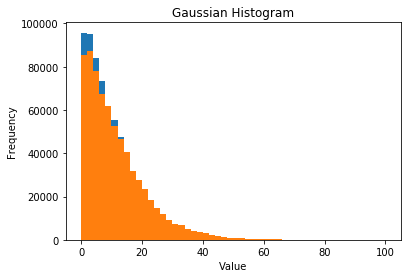

In [6]:
dists1=[]
dists2=[]
for user, locs in user_locs_big.items():
    for loc1 in locs:
        for loc2 in locs:
            if loc1 != loc2:
                try:
                    dists1.append(haversine_dist(loc1, loc2))
                    dists2.append(euclidian_dist(latlong_to_3d(loc1), latlong_to_3d(loc2)))
                except:
                    print(loc1, loc2)
                    raise



plt.hist(np.array(dists2) * .9, 50, range=(0,100))
plt.hist(dists1, 50, range=(0,100))
plt.title("Gaussian Histogram")
plt.xlabel("Value")
#plt.xscale('log')
plt.ylabel("Frequency")
plt.show()

In [7]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        #plt.loglog()
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

def show_map(locs):
    out = widgets.Output()
    with out:

        locs_3d = np.array([latlong_to_3d(loc) for loc in locs])       
        center = latlong_from_3d([
            sum(loc_3d[i] for loc_3d in locs_3d) / len(locs_3d)
            for i in range(3)
        ])
        map = Map(center=center, zoom=5, prefer_canvas=True)

        marker_cluster = MarkerCluster(
            maxClusterRadius=5,
            markers=[
                Marker(
                    #title=loc[0],
                    location=loc, 
                    #draggable=False,
                    #radius=10,
                    #stroke=False,
                    #fill_opacity=1,
                    #fill_color=matplotlib.colors.to_hex(color)
                )
                for loc in locs
            ])

        map.add_layer(marker_cluster);
        display(map)
        
        links = linkage(locs_3d)
        plt.figure(figsize=(10,10))
        dendrogram = fancy_dendrogram(
            links,
            truncate_mode='lastp',
            p=30,
            leaf_rotation=90.,
            leaf_font_size=12.,
            show_contracted=True,
            annotate_above=40,
            max_d=40,
        )
        plt.show()

    
    return out

In [ ]:
user_selector = widgets.Dropdown(
    options=[
        (user_names[user_id], user_id)
        for user_id in user_locs_big
    ],
    value=next(iter(user_locs_big)),
    description='User',
    disabled=False,
)
user_view = widgets.Box()
display(user_selector, user_view)

def show_user(user_id):
    user_view.children = [show_map(user_locs[user_id])]
user_selector.observe(lambda event: show_user(event['new']), names='value')
show_user(user_selector.value)


Dropdown(description='User', options=(('Larry', 'jfGevhcYLxY13Fa3drpzoA'), ('Yingjie', 'u9ps60AkkW62rimOHGLdbA…

Box()